<div style="display: flex;">
    <h1 style="margin: auto; font-weight: bold; color: black; padding: 30px 30px 0px 30px;" align="center"> Projet 5 : 
Segmentez des clients d'un site e-commerce
 </h1>
</div>

<div style="display: flex; margin: auto; padding: 5px 30px 0px 30px;" > <h2 style="width: 100%; text-align: center; color: black; float: left;" align="center">Notebook exploration </h2> 
</div>

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1. Importations librairies, fonctions, fichiers </h3>
</div>

In [1]:
import os
import io
import re
import gc
import itertools
import math
import plotly as pl
import plotly.express as px
import datetime as dt
import functools
import scipy.stats as st
import statsmodels.api as sm
import pyarrow.parquet as pq
import time as time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ppscore as pps
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import dill
import category_encoders as ce
from math import prod
from collections import Counter
from statsmodels.graphics.gofplots import qqplot
from mlxtend.plotting import plot_pca_correlation_graph
from scipy.stats import shapiro, normaltest, anderson, pearsonr, spearmanr, kendalltau
from sklearn import neighbors, metrics, preprocessing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.linear_model import BayesianRidge, LinearRegression
from ydata_profiling import ProfileReport
from collections import Counter
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.experimental import enable_iterative_imputer

In [2]:
def plot_histograms(df, cols, file_name=None, bins=30, figsize=(12, 7), skip_outliers=True, thresh=3, layout=(3, 3), save_enabled=False):

    fig = plt.figure(figsize=figsize)

    for i, c in enumerate(cols, 1):
        ax = fig.add_subplot(*layout, i)
        if skip_outliers:
            ser = df[c][np.abs(st.zscore(df[c]))<thresh]
        else:
            ser = df[c]
        ax.hist(ser,  bins=bins, color='black')
        ax.set_title(c)
        ax.vlines(df[c].mean(), *ax.get_ylim(),  color='blue', ls='-', lw=1.5)
        ax.vlines(df[c].median(), *ax.get_ylim(), color='red', ls='-.', lw=1.5)
        ax.vlines(df[c].mode()[0], *ax.get_ylim(), color='black', ls='--', lw=1.5)
        ax.legend(['mean', 'median', 'mode'])
        ax.title.set_fontweight('bold')
        # xmin, xmax = ax.get_xlim()
        # ax.set(xlim=(0, xmax/5))
        
    plt.tight_layout(w_pad=0.5, h_pad=0.65)
    #if save_enabled: plt.savefig(os.getcwd()+'/FIG/'+file_name, dpi=400);
    plt.show()

In [3]:
geolocations = pd.read_csv("olist_geolocation_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translations = pd.read_csv(
    "product_category_name_translation.csv")
products = pd.read_csv("olist_products_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Nettoyage </h3>
</div>

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. geolocations et sellers</h4>
</div>

In [4]:
geolocations


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
3                               1041       -23.544392       -46.639499   
4                               1035       -23.541578       -46.641607   
...                              ...              ...              ...   
1000158                        99950       -28.068639       -52.010705   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000161                        99980       -28.388932       -51.846871   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
0              sao paulo                SP  
1              sao paulo                SP  
2              sao paulo                SP  
3              sao paulo                SP  
4              sao paulo                SP  
...                  ...               ...  
1000158         tapejara                RS  
1000159   getulio vargas                RS  
1000160         tapejara                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS  

[1000163 rows x 5 columns]

In [5]:
sellers


seller_id  seller_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15                   13023   
1     d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2     ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3     c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4     51a04a8a6bdcb23deccc82b0b80742cf                   12914   
...                                ...                     ...   
3090  98dddbc4601dd4443ca174359b237166                   87111   
3091  f8201cab383e484733266d1906e2fdfa                   88137   
3092  74871d19219c7d518d0090283e03c137                    4650   
3093  e603cf3fec55f8697c9059638d6c8eb5                   96080   
3094  9e25199f6ef7e7c347120ff175652c3b                   12051   

            seller_city seller_state  
0              campinas           SP  
1            mogi guacu           SP  
2        rio de janeiro           RJ  
3             sao paulo           SP  
4     braganca paulista           SP  
...                 ...          ...  
3090            sarandi           PR  
3091            palhoca           SC  
3092          sao paulo           SP  
3093            pelotas           RS  
3094            taubate           SP  

[3095 rows x 4 columns]

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">b. products</h4>
</div>

In [6]:
products.describe(include='all')


product_id product_category_name  \
count                              32951                 32341   
unique                             32951                    73   
top     1e9e8ef04dbcff4541ed26657ea517e5       cama_mesa_banho   
freq                                   1                  3029   
mean                                 NaN                   NaN   
std                                  NaN                   NaN   
min                                  NaN                   NaN   
25%                                  NaN                   NaN   
50%                                  NaN                   NaN   
75%                                  NaN                   NaN   
max                                  NaN                   NaN   

        product_name_lenght  product_description_lenght  product_photos_qty  \
count          32341.000000                32341.000000        32341.000000   
unique                  NaN                         NaN                 NaN   
top                     NaN                         NaN                 NaN   
freq                    NaN                         NaN                 NaN   
mean              48.476949                  771.495285            2.188986   
std               10.245741                  635.115225            1.736766   
min                5.000000                    4.000000            1.000000   
25%               42.000000                  339.000000            1.000000   
50%               51.000000                  595.000000            1.000000   
75%               57.000000                  972.000000            3.000000   
max               76.000000                 3992.000000           20.000000   

        product_weight_g  product_length_cm  product_height_cm  \
count       32949.000000       32949.000000       32949.000000   
unique               NaN                NaN                NaN   
top                  NaN                NaN                NaN   
freq                 NaN                NaN                NaN   
mean         2276.472488          30.815078          16.937661   
std          4282.038731          16.914458          13.637554   
min             0.000000           7.000000           2.000000   
25%           300.000000          18.000000           8.000000   
50%           700.000000          25.000000          13.000000   
75%          1900.000000          38.000000          21.000000   
max         40425.000000         105.000000         105.000000   

        product_width_cm  
count       32949.000000  
unique               NaN  
top                  NaN  
freq                 NaN  
mean           23.196728  
std            12.079047  
min             6.000000  
25%            15.000000  
50%            20.000000  
75%            30.000000  
max           118.000000

In [7]:
# Verification outliers
products.loc[products['product_weight_g'] > 40000, :]
# 40kg une table pour enfant, beaucoup mais ok


product_id product_category_name  \
25166  26644690fde745fc4654719c3904e1db       cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
25166                 59.0                       534.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
25166           40425.0               13.0               65.0   

       product_width_cm  
25166              28.0

In [8]:
# Verification doublons
products.loc[products[['product_id']].duplicated(keep=False), :]


Empty DataFrame
Columns: [product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm]
Index: []

In [9]:
# Merge des catégories traduites
print(products.shape)
products = products.merge(
    product_category_name_translations, how="left", on="product_category_name")
print(products.shape)


(32951, 9)
(32951, 10)


In [10]:
print(products.isnull().sum())


product_id                         0
product_category_name            610
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    623
dtype: int64


In [11]:
# Remplissage des NaN
products['product_category_name_english'] = products['product_category_name_english'].fillna(
    "others")


In [12]:
# Supression colonnes inutiles
products = products.drop(columns=['product_name_lenght',
                                  'product_category_name', 'product_description_lenght',
                                  'product_photos_qty', 'product_length_cm',
                                  'product_height_cm', 'product_width_cm'])


In [13]:
# Identification NaN
products.loc[products['product_weight_g'].isna(), :]


product_id  product_weight_g  \
8578   09ff539a621711667c43eba6a3bd8466               NaN   
18851  5eb564652db742ff8f28759cd8d2652a               NaN   

      product_category_name_english  
8578                           baby  
18851                        others

In [14]:
# Remplacement par la médiane
products[products['product_category_name_english'] == 'baby'].describe().T
# nous prennons la médiane 850g pour remplacer le NaN baby
products['product_weight_g'].iloc[8578]=850

In [15]:
# Remplacement par la médiane
products[products['product_category_name_english'] == 'others'].describe().T
# nous prennons la médiane 750g pour remplacer le NaN baby
products['product_weight_g'].iloc[18851]=750

In [16]:
def most_common_words(labels, quantity):
    words = [i.split("_", 1)[0] for i in labels]
    counter = Counter(words).most_common(quantity)
    df = pd.DataFrame(counter, columns=["Word", "Occurence number"])\
        .sort_values(by="Occurence number", ascending=True)
    return df


In [17]:
categories = most_common_words(
    products["product_category_name_english"].tolist(), 30)
categories.sort_values("Occurence number", ascending=False, inplace=True)


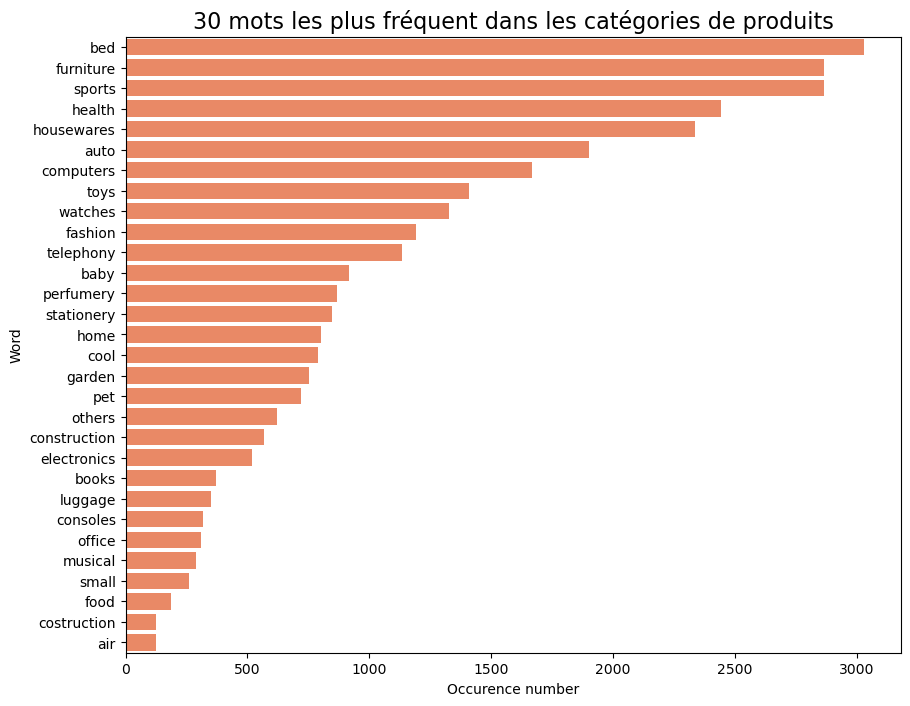

In [18]:
plt.figure(figsize=(10, 8))
sns.barplot(y="Word", x="Occurence number", data=categories, color='coral')
plt.title("30 mots les plus fréquent dans les catégories de produits", size=16)
plt.show()


In [19]:
product_categories = {

    "fashion_bags_accessories": "fashion",
    "fashio_female_clothing": "fashion",
    "fashion_sport": "fashion",
    "fashion_shoes": "fashion",
    "fashion_male_clothing": "fashion",
    "fashion_underwear_beach": "fashion",
    "fashion_childrens_clothes": "fashion",
    "cool_stuff": "fashion",
    "health_beauty": "fashion",
    "perfumery": "fashion",
    "watches_gifts": "fashion",


    "kitchen_dining_laundry_garden_furniture": "home",
    "portateis_cozinha_e_preparadores_de_alimentos": "home",
    "furniture_decor": "home",
    "office_furniture": "home",
    "furniture_bedroom": "home",
    "furniture_living_room": "home",
    "furniture_mattress_and_upholstery": "home",
    "arts_and_craftmanship": "home",
    "bed_bath_table": "home",
    "home_appliances": "home",
    "home_appliances_2": "home",
    "home_confort": "home",
    "home_comfort_2": "home",
    "air_conditioning": "home",
    "housewares": "home",
    "flowers": "home",


    "electronics": "electronics",
    "audio": "electronics",
    "tablets_printing_image": "electronics",
    "telephony": "electronics",
    "fixed_telephony": "electronics",
    "small_appliances": "electronics",
    "small_appliances_home_oven_and_coffee": "electronics",
    "computers_accessories": "electronics",
    "computers": "electronics",
    "pc_gamer": "electronics",


    "construction_tools_construction": "construction",
    "construction_tools_lights": "construction",
    "construction_tools_safety": "construction",
    "costruction_tools_garden": "construction",
    "costruction_tools_tools": "construction",
    "garden_tools": "construction",
    "home_construction": "construction",


    "sports_leisure": "leisure",
    "consoles_games": "leisure",
    "dvds_blu_ray": "leisure",
    "musical_instruments": "leisure",
    "toys": "leisure",
    "art": "leisure",
    "cine_photo": "leisure",
    "cds_dvds_musicals": "leisure",
    "music": "leisure",
    "books_general_interest": "leisure",
    "books_imported": "leisure",
    "books_technical": "leisure",


    "christmas_supplies": "others",
    "stationery": "others",
    "party_supplies": "others",
    "auto": "others",
    "luggage_accessories": "others",
    "signaling_and_security": "others",
    "agro_industry_and_commerce": "others",
    "security_and_services": "others",
    "market_place": "others",
    "pet_shop": "others",
    "industry_commerce_and_business": "others",
    "baby": "others",
    "diapers_and_hygiene": "others",
    "drinks": "others",
    "food": "others",
    "food_drink": "others",
    "la_cuisine": "others",
    "unknown": "others",
}


In [20]:
# Création d'une catégorie plus générale avec 6 groupes
products["product_category"] = products["product_category_name_english"].replace(
    product_categories)


In [21]:
product = pd.get_dummies(products.product_category, dtype=int)
product.head()


construction  electronics  fashion  home  leisure  others
0             0            0        1     0        0       0
1             0            0        0     0        1       0
2             0            0        0     0        1       0
3             0            0        0     0        0       1
4             0            0        0     1        0       0

In [22]:
products = products.join(product)
products


product_id  product_weight_g  \
0      1e9e8ef04dbcff4541ed26657ea517e5             225.0   
1      3aa071139cb16b67ca9e5dea641aaa2f            1000.0   
2      96bd76ec8810374ed1b65e291975717f             154.0   
3      cef67bcfe19066a932b7673e239eb23d             371.0   
4      9dc1a7de274444849c219cff195d0b71             625.0   
...                                 ...               ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0           12300.0   
32947  bf4538d88321d0fd4412a93c974510e6            1700.0   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c            1400.0   
32949  83808703fc0706a22e264b9d75f04a2e             700.0   
32950  106392145fca363410d287a815be6de4            2083.0   

      product_category_name_english product_category  construction  \
0                         perfumery          fashion             0   
1                               art          leisure             0   
2                    sports_leisure          leisure             0   
3                              baby           others             0   
4                        housewares             home             0   
...                             ...              ...           ...   
32946               furniture_decor             home             0   
32947     construction_tools_lights     construction             1   
32948                bed_bath_table             home             0   
32949         computers_accessories      electronics             0   
32950                bed_bath_table             home             0   

       electronics  fashion  home  leisure  others  
0                0        1     0        0       0  
1                0        0     0        1       0  
2                0        0     0        1       0  
3                0        0     0        0       1  
4                0        0     1        0       0  
...            ...      ...   ...      ...     ...  
32946            0        0     1        0       0  
32947            0        0     0        0       0  
32948            0        0     1        0       0  
32949            1        0     0        0       0  
32950            0        0     1        0       0  

[32951 rows x 10 columns]

In [23]:
def plot_barplots(data, cols, file_name=None, figsize=(12, 7), layout=(2, 3), save_enabled=False):

    fig = plt.figure(figsize=figsize)
    for i, c in enumerate(cols, 1):
        ax = fig.add_subplot(*layout, i)
        ser = data[c].value_counts()
        n_cat = ser.shape[0]
        if n_cat>15:
            ser[0:15].plot.bar(color='green', ec='k', ax=ax)
        else:
            ser.plot.bar(color='green', ec='k', ax=ax)
        ax.set_title(c[0:17]+f' ({n_cat})', fontweight='bold')
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [24]:
pro = ['product_category_name_english', 'product_category']


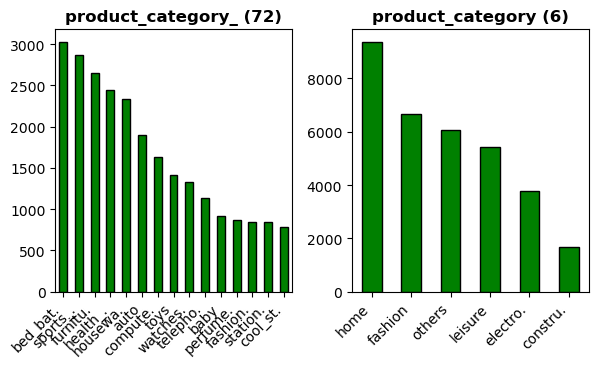

In [25]:
plot_barplots(data=products, cols=pro, figsize=(15, 10), layout=(3, 5))
plt.show()


In [26]:
# Supression des catégories après encodage
products = products.drop(
    columns=['product_category_name_english', 'product_category'])


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">c. orders</h4>
</div>

In [27]:
orders.describe(include='all')


order_id                       customer_id  \
count                              99441                             99441   
unique                             99441                             99441   
top     e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
freq                                   1                                 1   

       order_status order_purchase_timestamp    order_approved_at  \
count         99441                    99441                99281   
unique            8                    98875                90733   
top       delivered      2018-04-11 10:48:14  2018-02-27 04:31:10   
freq          96478                        3                    9   

       order_delivered_carrier_date order_delivered_customer_date  \
count                         97658                         96476   
unique                        81018                         95664   
top             2018-05-09 15:48:00           2018-05-08 23:38:46   
freq                             47                             3   

       order_estimated_delivery_date  
count                          99441  
unique                           459  
top              2017-12-20 00:00:00  
freq                             522

In [28]:
# Vérification des doublons
orders.loc[orders[['order_id']].duplicated(keep=False), :]


Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date]
Index: []

In [29]:
# Vérification des outliers
orders.loc[orders['order_id'] == "03caa2c082116e1d31e67e9ae3700499", :]
# commande outlier de 13000e pour de la téléphonie fixe
orders = orders.drop([13390])


In [30]:
orders['order_status'].value_counts()


delivered      96477
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [31]:
# Filtrage des commandes
orders = orders.loc[orders['order_status'] == "delivered", :]


In [32]:
# Supression colonnes inutiles
orders = orders.drop(columns=['order_approved_at',
                              'order_status',
                              'order_delivered_carrier_date',
                              'order_delivered_customer_date',
                              'order_estimated_delivery_date'])


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">d. order_items</h4>
</div>

In [33]:
order_items.describe(include='all')


order_id  order_item_id  \
count                             112650  112650.000000   
unique                             98666            NaN   
top     8272b63d03f5f79c56e9e4120aec44ef            NaN   
freq                                  21            NaN   
mean                                 NaN       1.197834   
std                                  NaN       0.705124   
min                                  NaN       1.000000   
25%                                  NaN       1.000000   
50%                                  NaN       1.000000   
75%                                  NaN       1.000000   
max                                  NaN      21.000000   

                              product_id                         seller_id  \
count                             112650                            112650   
unique                             32951                              3095   
top     aca2eb7d00ea1a7b8ebd4e68314663af  6560211a19b47992c3666cc44a7e94c0   
freq                                 527                              2033   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

        shipping_limit_date          price  freight_value  
count                112650  112650.000000  112650.000000  
unique                93318            NaN            NaN  
top     2017-07-21 18:25:23            NaN            NaN  
freq                     21            NaN            NaN  
mean                    NaN     120.653739      19.990320  
std                     NaN     183.633928      15.806405  
min                     NaN       0.850000       0.000000  
25%                     NaN      39.900000      13.080000  
50%                     NaN      74.990000      16.260000  
75%                     NaN     134.900000      21.150000  
max                     NaN    6735.000000     409.680000

In [34]:
# Supression des colonnes redondantes ou pas informatives
order_items = order_items.drop(
    columns=['seller_id', 'shipping_limit_date', 'price', 'freight_value'])


In [35]:
# Merge avec les produits et sum()
order_items = pd.merge(order_items, products, on="product_id")
order_items = order_items.groupby(['order_id']).sum()


In [36]:
order_items = order_items.drop(columns=["order_item_id"])
order_items = order_items.rename(columns={'product_weight_g': 'order_weight'})


In [37]:
print(order_items.isnull().sum())


order_weight    0
construction    0
electronics     0
fashion         0
home            0
leisure         0
others          0
dtype: int64


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">e. order_reviews</h4>
</div>

In [38]:
order_reviews.describe(include='all')


review_id                          order_id  \
count                              99224                             99224   
unique                             98410                             98673   
top     7b606b0d57b078384f0b58eac1d41d78  c88b1d1b157a9999ce368f218a407141   
freq                                   3                                 3   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

        review_score review_comment_title review_comment_message  \
count   99224.000000                11568                  40977   
unique           NaN                 4527                  36159   
top              NaN            Recomendo              Muito bom   
freq             NaN                  423                    230   
mean        4.086421                  NaN                    NaN   
std         1.347579                  NaN                    NaN   
min         1.000000                  NaN                    NaN   
25%         4.000000                  NaN                    NaN   
50%         5.000000                  NaN                    NaN   
75%         5.000000                  NaN                    NaN   
max         5.000000                  NaN                    NaN   

       review_creation_date review_answer_timestamp  
count                 99224                   99224  
unique                  636                   98248  
top     2017-12-19 00:00:00     2017-06-15 23:21:05  
freq                    463                       4  
mean                    NaN                     NaN  
std                     NaN                     NaN  
min                     NaN                     NaN  
25%                     NaN                     NaN  
50%                     NaN                     NaN  
75%                     NaN                     NaN  
max                     NaN                     NaN

In [39]:
# Vérification des outliers
order_reviews.loc[order_reviews['order_id']
                  == "03caa2c082116e1d31e67e9ae3700499", :]
order_reviews["review_comment_message"].iloc[29745]


'Peço por favor verificar a entrega do pedido, pois não recebemos.'

In [40]:
# Vérification des doublons
order_reviews.loc[order_reviews[['order_id']].duplicated(keep=False), :]


review_id                          order_id  \
30     540e7bbb2d06cfb7f85f3a88ba7ac97f  cf73e2cb1f4a9480ed70c154da3d954a   
344    a0a641414ff718ca079b3967ef5c2495  169d7e0fd71d624d306f132acd791cbe   
498    505a882ba08a689682a4afc6eb4e5965  1c308eca3f339414a92e518e2a2e5ee9   
764    c5976a5a98e854fb23d7e03c6754ae60  2002ea16e75277eaa0b5d78632048540   
778    62c7722239b976d943ec0d430cfe890e  1d297b4800ed1a3c5b0944d84c01ee99   
...                                 ...                               ...   
98989  dfb3db02188d809d5cd199496b6da87e  c0db7d31ace61fc360a3eaa34dd3457c   
99108  2c6c08892b83ba4c1be33037c2842294  42ae1967f68c90bb325783ac55d761ce   
99164  2afe63a67dfd99b3038f568fb47ee761  c5334d330e36d2a810a7a13c72e135ee   
99178  44d1e9165ec54b1d89d33594856af859  a7dbcf5043158d6fa72859eead2f3d10   
99199  40743b46a0ee86375cedb95e82b78d75  3e93213bb8fdda91186b4018b2fe0030   

       review_score review_comment_title  \
30                5                  NaN   
344               5                  NaN   
498               2                  NaN   
764               5                  NaN   
778               3                  NaN   
...             ...                  ...   
98989             5                  NaN   
99108             4                  NaN   
99164             5                  NaN   
99178             4                  NaN   
99199             5      OTIMA EMBALAGEM   

                                  review_comment_message review_creation_date  \
30                                                   NaN  2018-01-18 00:00:00   
344                                                  NaN  2018-03-04 00:00:00   
498                                                  NaN  2017-12-28 00:00:00   
764                                                  NaN  2017-08-08 00:00:00   
778                                                  NaN  2017-10-22 00:00:00   
...                                                  ...                  ...   
98989                                                NaN  2018-02-17 00:00:00   
99108  Chegou um pouco amassada, mas nada de mais, e ...  2017-07-03 00:00:00   
99164  Muito bom, produto conforme anunciado, entrega...  2018-03-03 00:00:00   
99178                                                NaN  2017-05-24 00:00:00   
99199                                                NaN  2018-08-08 00:00:00   

      review_answer_timestamp  
30        2018-01-18 19:12:30  
344       2018-03-06 20:12:53  
498       2017-12-31 20:25:02  
764       2017-08-10 11:11:29  
778       2017-10-31 15:33:32  
...                       ...  
98989     2018-02-19 19:29:19  
99108     2017-07-05 19:06:59  
99164     2018-03-04 22:56:47  
99178     2017-05-24 23:15:21  
99199     2018-08-08 16:56:16  

[1098 rows x 7 columns]

In [41]:
# Remplissage NaN
order_reviews['review_comment_message'] = order_reviews['review_comment_message'].str.len(
).fillna(0)
order_reviews['review_comment_title'] = order_reviews['review_comment_title'].str.len(
).fillna(0)
order_reviews['review_comment'] = order_reviews['review_comment_title'] + \
    order_reviews['review_comment_message']
order_reviews


review_id                          order_id  \
0      7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1      80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2      228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3      e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4      f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
...                                 ...                               ...   
99219  574ed12dd733e5fa530cfd4bbf39d7c9  2a8c23fee101d4d5662fa670396eb8da   
99220  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
99221  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
99222  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
99223  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score  review_comment_title  review_comment_message  \
0                 4                   0.0                     0.0   
1                 5                   0.0                     0.0   
2                 5                   0.0                     0.0   
3                 5                   0.0                    37.0   
4                 5                   0.0                   100.0   
...             ...                   ...                     ...   
99219             5                   0.0                     0.0   
99220             5                   0.0                     0.0   
99221             5                   0.0                    67.0   
99222             4                   0.0                     0.0   
99223             1                   0.0                    85.0   

      review_creation_date review_answer_timestamp  review_comment  
0      2018-01-18 00:00:00     2018-01-18 21:46:59             0.0  
1      2018-03-10 00:00:00     2018-03-11 03:05:13             0.0  
2      2018-02-17 00:00:00     2018-02-18 14:36:24             0.0  
3      2017-04-21 00:00:00     2017-04-21 22:02:06            37.0  
4      2018-03-01 00:00:00     2018-03-02 10:26:53           100.0  
...                    ...                     ...             ...  
99219  2018-07-07 00:00:00     2018-07-14 17:18:30             0.0  
99220  2017-12-09 00:00:00     2017-12-11 20:06:42             0.0  
99221  2018-03-22 00:00:00     2018-03-23 09:10:43            67.0  
99222  2018-07-01 00:00:00     2018-07-02 12:59:13             0.0  
99223  2017-07-03 00:00:00     2017-07-03 21:01:49            85.0  

[99224 rows x 8 columns]

In [42]:
# Regroupement par order_id (plusieurs review par commandes) et suppression colonnes inutiles
order_reviews = order_reviews.groupby(by=["order_id"]).mean()
order_reviews = order_reviews.drop(
    columns=["review_comment_title",	"review_comment_message"])


In [43]:
print(order_reviews.isnull().sum())


review_score      0
review_comment    0
dtype: int64


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">f. order_payments</h4>
</div>

In [44]:
order_payments.describe(include='all')
# max(payment_value = 13664) à explorer


order_id  payment_sequential payment_type  \
count                             103886       103886.000000       103886   
unique                             99440                 NaN            5   
top     fa65dad1b0e818e3ccc5cb0e39231352                 NaN  credit_card   
freq                                  29                 NaN        76795   
mean                                 NaN            1.092679          NaN   
std                                  NaN            0.706584          NaN   
min                                  NaN            1.000000          NaN   
25%                                  NaN            1.000000          NaN   
50%                                  NaN            1.000000          NaN   
75%                                  NaN            1.000000          NaN   
max                                  NaN           29.000000          NaN   

        payment_installments  payment_value  
count          103886.000000  103886.000000  
unique                   NaN            NaN  
top                      NaN            NaN  
freq                     NaN            NaN  
mean                2.853349     154.100380  
std                 2.687051     217.494064  
min                 0.000000       0.000000  
25%                 1.000000      56.790000  
50%                 1.000000     100.000000  
75%                 4.000000     171.837500  
max                24.000000   13664.080000

In [45]:
order_payments.loc[order_payments['payment_value'] == 13664.080000, :]
# nous verrons après les merges de quel produit il s'agit et adapterons le traitement en fonction.


order_id  payment_sequential payment_type  \
52107  03caa2c082116e1d31e67e9ae3700499                   1  credit_card   

       payment_installments  payment_value  
52107                     1       13664.08

In [46]:
# Vérification des doublons
order_payments.loc[order_payments[['order_id']].duplicated(keep=False), :]


order_id  payment_sequential payment_type  \
25      5cfd514482e22bc992e7693f0e3e8df7                   2      voucher   
35      b2bb080b6bc860118a246fd9b6fad6da                   1  credit_card   
75      3689194c14ad4e2e7361ebd1df0e77b0                   2      voucher   
84      723e462ce1ee50e024887c0b403130f3                   1  credit_card   
102     21b8b46679ea6482cbf911d960490048                   2      voucher   
...                                  ...                 ...          ...   
103778  fd86c80924b4be8fb7f58c4ecc680dae                   1  credit_card   
103817  6d4616de4341417e17978fe57aec1c46                   1  credit_card   
103860  31bc09fdbd701a7a4f9b55b5955b8687                   6      voucher   
103869  c9b01bef18eb84888f0fd071b8413b38                   1  credit_card   
103874  d41f1036712e18ee525939d08b7a1c98                   1  credit_card   

        payment_installments  payment_value  
25                         1          45.17  
35                         1         173.84  
75                         1          57.53  
84                         1          13.80  
102                        1          43.12  
...                      ...            ...  
103778                     1          76.10  
103817                     1          19.18  
103860                     1          77.99  
103869                     6         238.16  
103874                     1           3.57  

[7407 rows x 5 columns]

In [47]:
order_payments = order_payments.groupby(by=["order_id"]).sum()
order_payments = order_payments.drop(columns=["payment_installments"])


In [48]:
print(order_payments.isnull().sum())


payment_sequential    0
payment_value         0
dtype: int64


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">g. customers</h4>
</div>

In [49]:
# customer_id = Chaque commande a un numéro de client unique.
# customer_unique_id = identifiant unique d'un client.


In [50]:
print(customers['customer_id'].nunique())
customers.loc[customers[['customer_id']].duplicated(keep=False), :]


99441


Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state]
Index: []

In [51]:
print(customers['customer_unique_id'].nunique())
# Nous utiliserons cette clé car il y a des doublons en haut
customers.loc[customers[['customer_unique_id']].duplicated(keep=False), :]
# customers = customers.drop(columns=['customer_id'])
# customers = customers.rename(columns={'customer_unique_id':'customer_id'})


96096


customer_id                customer_unique_id  \
5      879864dab9bc3047522c92c82e1212b8  4c93744516667ad3b8f1fb645a3116a4   
8      5adf08e34b2e993982a47070956c5c65  1175e95fb47ddff9de6b2b06188f7e0d   
13     eabebad39a88bb6f5b52376faec28612  295c05e81917928d76245e842748184d   
32     2d5831cb2dff7cdefba62e950ae3dc7b  e9dd12dca17352644a959d9dea133935   
33     b2bed119388167a954382cca36c4777f  e079b18794454de9d2be5c12b4392294   
...                                 ...                               ...   
99324  5b46a0d983eec8c97363bea78d4a69dd  8bab3162259edfaadd1ea2e1fe7f58dc   
99327  c1affa46f9f3b514555259049a0307b9  12ab9334b1240d6d037f2b0102a49571   
99336  ebf46ff530343a129926adc1f831dea4  0ee57f62666561b72f2ceacad0230cbf   
99353  282fbce48e4d2077aad602dd125c9225  0ceb502fc33a2ad327b08288c5310e2e   
99406  d9110683c7a282144e9fc97660026a28  5cbfdb85ec130898108b32c50d619c39   

       customer_zip_code_prefix         customer_city customer_state  
5                         89254        jaragua do sul             SC  
8                         81560              curitiba             PR  
13                         5704             sao paulo             SP  
32                        42800              camacari             BA  
33                        27525               resende             RJ  
...                         ...                   ...            ...  
99324                     31565        belo horizonte             MG  
99327                     38050               uberaba             MG  
99336                      9530    sao caetano do sul             SP  
99353                     29134                 viana             ES  
99406                     74980  aparecida de goiania             GO  

[6342 rows x 5 columns]

In [52]:
customers = customers.drop(
    columns=['customer_zip_code_prefix', 'customer_city'])


In [53]:
print(customers.isnull().sum())


customer_id           0
customer_unique_id    0
customer_state        0
dtype: int64


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">h. merge finaux</h4>
</div>

In [54]:
df = pd.merge(orders, order_payments, on="order_id")
df = pd.merge(df, customers, on="customer_id")
df = pd.merge(df, order_items, on="order_id")
df = pd.merge(df, order_reviews, on="order_id")
df


order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
95825  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
95826  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
95827  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
95828  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
95829  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_purchase_timestamp  payment_sequential  payment_value  \
0          2017-10-02 10:56:33                   6          38.71   
1          2018-07-24 20:41:37                   1         141.46   
2          2018-08-08 08:38:49                   1         179.12   
3          2017-11-18 19:28:06                   1          72.20   
4          2018-02-13 21:18:39                   1          28.62   
...                        ...                 ...            ...   
95825      2017-03-09 09:54:05                   1          85.08   
95826      2018-02-06 12:58:58                   1         195.00   
95827      2017-08-27 14:46:43                   1         271.01   
95828      2018-01-08 21:28:27                   1         441.16   
95829      2018-03-08 20:57:30                   1          86.86   

                     customer_unique_id customer_state  order_weight  \
0      7c396fd4830fd04220f754e42b4e5bff             SP         500.0   
1      af07308b275d755c9edb36a90c618231             BA         400.0   
2      3a653a41f6f9fc3d2a113cf8398680e8             GO         420.0   
3      7c142cf63193a1473d2e66489a9ae977             RN         450.0   
4      72632f0f9dd73dfee390c9b22eb56dd6             SP         250.0   
...                                 ...            ...           ...   
95825  6359f309b166b0196dbf7ad2ac62bb5a             SP        1175.0   
95826  da62f9e57a76d978d02ab5362c509660             SP        4950.0   
95827  737520a9aad80b3fbbdad19b66b37b30             BA       13300.0   
95828  5097a5312c8b157bb7be58ae360ef43c             RJ       13100.0   
95829  60350aa974b26ff12caad89e55993bd6             PR         150.0   

       construction  electronics  fashion  home  leisure  others  \
0                 0            0        0     1        0       0   
1                 0            0        1     0        0       0   
2                 0            0        0     0        0       1   
3                 0            0        0     0        0       1   
4                 0            0        0     0        0       1   
...             ...          ...      ...   ...      ...     ...   
95825             0            0        1     0        0       0   
95826             0            0        0     0        0       1   
95827             0            0        0     1        0       0   
95828             0            2        0     0        0       0   
95829             0            0        1     0        0       0   

       review_score  review_comment  
0               4.0           170.0  
1               4.0            36.0  
2               5.0             0.0  
3               5.0           105.0  
4               5.0             0.0  
...             ...             ...  
95825           5.0             0.0  
95826           4.0            44.0  
95827           5.0            28.0  
95828           2.0            53.0  
95829           5.0             0.0  

[95830 rows x 16 columns]

In [55]:
df.loc[customers[['customer_unique_id']].duplicated(keep=False), :]


order_id                       customer_id  \
5      a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   
8      e69bfb5eb88e0ed6a785585b27e16dbf  31ad1d1b63eb9962463f764d4e6e0c9d   
13     432aaf21d85167c2c86ec9448c4e42cc  3df704f53d3f1d4818840b34ec672a9f   
32     b276e4f8c0fb86bd82fce576f21713e0  cf8ffeddf027932e51e4eae73b384059   
33     8563039e855156e48fccee4d611a3196  5f16605299d698660e0606f7eae2d2f9   
...                                 ...                               ...   
95716  316c859aa0c2b794a3db879c5eb09153  041cb229c816ff7ddc6e6bd21df556b7   
95726  b4cec7d0224b919cac7a6d513cc0884f  95e719d72780395652555c67d60d1530   
95772  5515bb89b509d97aa78d434bc96ecee3  47a7e021c968ec3abacc05c3dc44cfdd   
95801  4a69678ecf74bfd34260031c04329b68  eb19f77ffd29917f353d12152b0c0de1   
95811  dfc6eb45a2753ed9e6c6ef4987b44503  a046c690e0564ffde0ce611b5eee2c30   

      order_purchase_timestamp  payment_sequential  payment_value  \
5          2017-07-09 21:57:05                   1         175.26   
8          2017-07-29 11:55:02                   3         169.76   
13         2018-03-01 14:14:28                   1          54.36   
32         2018-07-29 23:34:51                   1         188.41   
33         2018-02-17 15:59:46                   1         106.95   
...                        ...                 ...            ...   
95716      2017-12-11 19:30:26                   1          76.76   
95726      2018-02-06 12:46:51                   1         212.49   
95772      2018-07-14 20:17:16                   1          53.65   
95801      2018-07-22 16:58:38                   1         172.41   
95811      2018-05-25 17:05:17                   1         173.63   

                     customer_unique_id customer_state  order_weight  \
5      80bb27c7c16e8f973207a5086ab329e2             PR        7150.0   
8      299905e3934e9e181bfb2e164dd4b4f8             SP        9750.0   
13     04cf8185c71090d28baa4407b2e6d600             SP         583.0   
32     6cbe8a392b76916e84c2faf69d0d0da0             SP         425.0   
33     92fd8aa5948e20c43a014c44c025c5e1             TO         850.0   
...                                 ...            ...           ...   
95716  8def2fed2130bb3f799d89f4d6a334e0             BA         250.0   
95726  3ac3b01377800633adab4a68b1c296b0             SP        2134.0   
95772  f359e6e1120bad1d7cccc6213c2e9601             BA         250.0   
95801  58a3b88ec0ed98474b1bb2630b277ed4             SP        2500.0   
95811  4a7ce65ce092885c0af12dc0001457cf             MG        5150.0   

       construction  electronics  fashion  home  leisure  others  \
5                 0            0        0     0        0       1   
8                 0            0        0     1        0       0   
13                0            0        0     0        1       0   
32                0            0        1     0        0       0   
33                1            0        0     0        0       0   
...             ...          ...      ...   ...      ...     ...   
95716             0            0        1     0        0       0   
95726             0            0        1     0        0       0   
95772             0            0        1     0        0       0   
95801             0            0        0     0        0       1   
95811             1            0        0     0        0       0   

       review_score  review_comment  
5               4.0             0.0  
8               5.0             0.0  
13              4.0            17.0  
32              5.0             2.0  
33              5.0           101.0  
...             ...             ...  
95716           5.0             0.0  
95726           4.0             0.0  
95772           5.0             2.0  
95801           5.0             0.0  
95811           5.0             0.0  

[6119 rows x 16 columns]

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3. Création de variable : Segmentation RFM </h3>
</div>

In [56]:
from statistics import quantiles


def quintile_score(X, quantile, rfm_feature):
    """
    Method used to attribute score (between 1 and 5) based on positions into quantiles.
    5 is the highest value. 1 is the worst value.
    The bigger the X, the bigger the score

    Parameters:
    -----------------
        X (int): Feature value to attribute score
        quantiles (pandas.DataFrame): Dataset with values at the given quantile over RFM axis
        rfm_feature(str): Feature identifier

    Returns:
    -----------------
        score (int)
    """

    if rfm_feature != "recency":
        if X <= quantiles[rfm_feature][.2]:
            return 1
        elif X <= quantiles[rfm_feature][.4]:
            return 2
        elif X <= quantiles[rfm_feature][.6]:
            return 3
        elif X <= quantiles[rfm_feature][.8]:
            return 4
        else:
            return 5
    else:
        if X <= quantiles[rfm_feature][.2]:
            return 5
        elif X <= quantiles[rfm_feature][.4]:
            return 4
        elif X <= quantiles[rfm_feature][.6]:
            return 3
        elif X <= quantiles[rfm_feature][.8]:
            return 2
        else:
            return 1


def RFM_segments(score):
    """
    Method used to make the customer segmentation based on Exponea.

    For more details, you can see the links below
    - https://docs.exponea.com/docs/rfm-segmentation
    - https://docs.exponea.com/docs/rfm-segmentation-business-use

    Parameters:
    -----------------
        score (int): Score of the customer

    Returns:
    -----------------
        customer_segment (string)
    """

    exponea_segmentation = {
        "champions": [555, 554, 544, 545, 454, 455, 445],
        "loyal": [543, 444, 435, 355, 354, 345, 344, 335],
        "potential_loyalist": [553, 551, 552, 541, 542, 533, 532,
                               531, 452, 451, 442, 441, 431, 453,
                               433, 432, 423, 353, 352, 351, 342,
                               341, 333, 323],
        "new_customers": [512, 511, 422, 421, 412, 411, 311],
        "promising": [525, 524, 523, 522, 521, 515, 514, 513, 425,
                      424, 413, 414, 415, 315, 314, 313],
        "need_attention": [535, 534, 443, 434, 343, 334, 325, 324],
        "about_to_sleep": [331, 321, 312, 221, 213, 231, 241, 251],
        "at_risk": [255, 254, 245, 244, 253, 252, 243, 242, 235,
                    234, 225, 224, 153, 152, 145, 143, 142, 135,
                    134, 133, 125, 124],
        "cannot_lose_them": [155, 154, 144, 214, 215, 115, 114, 113],
        "hibernating_customers": [332, 322, 231, 241, 251, 233, 232,
                                  223, 222, 132, 123, 122, 212, 211],
        "lost_customers": [111, 112, 121, 131, 141, 151]
    }

    customer_segment = [
        key for key, values in exponea_segmentation.items() if score in values]

    return customer_segment[0]


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Recency </h4>
</div>

In [57]:
from datetime import date
df['order_purchase_timestamp'] = pd.to_datetime(
    df['order_purchase_timestamp']).dt.date
df['order_purchase_timestamp']


0        2017-10-02
1        2018-07-24
2        2018-08-08
3        2017-11-18
4        2018-02-13
            ...    
95825    2017-03-09
95826    2018-02-06
95827    2017-08-27
95828    2018-01-08
95829    2018-03-08
Name: order_purchase_timestamp, Length: 95830, dtype: object

In [58]:
recency = df.groupby(by='customer_unique_id',
                        as_index=False)['order_purchase_timestamp'].max()
recency.columns = ['customer_unique_id', 'order_purchase_timestamp']
recent_date = recency['order_purchase_timestamp'].max()
recency['recency'] = recency['order_purchase_timestamp'].apply(
    lambda x: (recent_date - x).days)
recency.head()


customer_unique_id order_purchase_timestamp  recency
0  0000366f3b9a7992bf8c76cfdf3221e2               2018-05-10      111
1  0000b849f77a49e4a4ce2b2a4ca5be3f               2018-05-07      114
2  0000f46a3911fa3c0805444483337064               2017-03-10      537
3  0000f6ccb0745a6a4b88665a16c9f078               2017-10-12      321
4  0004aac84e0df4da2b147fca70cf8255               2017-11-14      288

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">b. Frequency </h4>
</div>

In [59]:
frequency = df.drop_duplicates().groupby(
    by=['customer_unique_id'], as_index=False)['order_purchase_timestamp'].count()
frequency.columns = ['customer_unique_id', 'frequency']
frequency.max()


customer_unique_id    ffffd2657e2aad2907e67c3e9daecbeb
frequency                                           15
dtype: object

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">c. Monetary </h4>
</div>

In [60]:
monetary = df.groupby(by='customer_unique_id', as_index=False)[
    'payment_value'].sum()
monetary.columns = ['customer_unique_id', 'monetary']
monetary


customer_unique_id  monetary
0      0000366f3b9a7992bf8c76cfdf3221e2    141.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f     27.19
2      0000f46a3911fa3c0805444483337064     86.22
3      0000f6ccb0745a6a4b88665a16c9f078     43.62
4      0004aac84e0df4da2b147fca70cf8255    196.89
...                                 ...       ...
92748  fffcf5a5ff07b0908bd4e2dbc735a684   2067.42
92749  fffea47cd6d3cc0a88bd621562a9d061     84.58
92750  ffff371b4d645b6ecea244b27531430a    112.46
92751  ffff5962728ec6157033ef9805bacc48    133.69
92752  ffffd2657e2aad2907e67c3e9daecbeb     71.56

[92753 rows x 2 columns]

In [61]:
rfm = pd.merge(recency, frequency, on="customer_unique_id")
rfm = pd.merge(rfm, monetary, on="customer_unique_id")


In [62]:
rfm.loc[rfm[['customer_unique_id']].duplicated(keep=False), :]


Empty DataFrame
Columns: [customer_unique_id, order_purchase_timestamp, recency, frequency, monetary]
Index: []

In [63]:
quantiles = rfm[["recency", "frequency", "monetary"]
                ].quantile([.2, .4, .6, .8])
quantiles


recency  frequency  monetary
0.2     91.0        1.0    55.240
0.4    176.0        1.0    87.298
0.6    268.0        1.0   132.524
0.8    382.0        1.0   208.200

In [64]:
rfm["r_score"] = rfm["recency"].apply(
    lambda X: quintile_score(X, quantiles, "recency"))
rfm["f_score"] = rfm["frequency"].apply(
    lambda X: quintile_score(X, quantiles, "frequency"))
rfm["m_score"] = rfm["monetary"].apply(
    lambda X: quintile_score(X, quantiles, "monetary"))


In [65]:
rfm.head()


customer_unique_id order_purchase_timestamp  recency  \
0  0000366f3b9a7992bf8c76cfdf3221e2               2018-05-10      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               2018-05-07      114   
2  0000f46a3911fa3c0805444483337064               2017-03-10      537   
3  0000f6ccb0745a6a4b88665a16c9f078               2017-10-12      321   
4  0004aac84e0df4da2b147fca70cf8255               2017-11-14      288   

   frequency  monetary  r_score  f_score  m_score  
0          1    141.90        4        1        4  
1          1     27.19        4        1        1  
2          1     86.22        1        1        2  
3          1     43.62        2        1        1  
4          1    196.89        2        1        4

In [66]:
rfm[rfm["r_score"] == 5].sort_values("recency", ascending=True).head()


customer_unique_id order_purchase_timestamp  recency  \
46441  7febafa06d9d8f232a900a2937f04338               2018-08-29        0   
33594  5c58de6fb80e93396e2f35642666b693               2018-08-29        0   
89895  f80013faf776e37bcea7634d59c2181e               2018-08-29        0   
66387  b701bebbdf478f5500348f03aff62121               2018-08-29        0   
1505   0421e7a23f21e5d54efed456aedbc513               2018-08-29        0   

       frequency  monetary  r_score  f_score  m_score  
46441          1     61.29        5        1        2  
33594          1    510.96        5        1        5  
89895          1     74.21        5        1        2  
66387          1     33.23        5        1        1  
1505           1    119.42        5        1        3

In [67]:
rfm["rfm_score"] = rfm["r_score"].astype(
    str) + rfm["f_score"].astype(str) + rfm["m_score"].astype(str)
rfm["rfm_score"] = rfm["rfm_score"].astype("int32")


In [68]:
rfm.head()


customer_unique_id order_purchase_timestamp  recency  \
0  0000366f3b9a7992bf8c76cfdf3221e2               2018-05-10      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               2018-05-07      114   
2  0000f46a3911fa3c0805444483337064               2017-03-10      537   
3  0000f6ccb0745a6a4b88665a16c9f078               2017-10-12      321   
4  0004aac84e0df4da2b147fca70cf8255               2017-11-14      288   

   frequency  monetary  r_score  f_score  m_score  rfm_score  
0          1    141.90        4        1        4        414  
1          1     27.19        4        1        1        411  
2          1     86.22        1        1        2        112  
3          1     43.62        2        1        1        211  
4          1    196.89        2        1        4        214

In [69]:
rfm["rfm_score_label"] = rfm["rfm_score"].apply(lambda X: RFM_segments(X))


In [70]:
rfm.head()


customer_unique_id order_purchase_timestamp  recency  \
0  0000366f3b9a7992bf8c76cfdf3221e2               2018-05-10      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               2018-05-07      114   
2  0000f46a3911fa3c0805444483337064               2017-03-10      537   
3  0000f6ccb0745a6a4b88665a16c9f078               2017-10-12      321   
4  0004aac84e0df4da2b147fca70cf8255               2017-11-14      288   

   frequency  monetary  r_score  f_score  m_score  rfm_score  \
0          1    141.90        4        1        4        414   
1          1     27.19        4        1        1        411   
2          1     86.22        1        1        2        112   
3          1     43.62        2        1        1        211   
4          1    196.89        2        1        4        214   

         rfm_score_label  
0              promising  
1          new_customers  
2         lost_customers  
3  hibernating_customers  
4       cannot_lose_them

In [71]:
rfm[rfm["frequency"] >= 3]


customer_unique_id order_purchase_timestamp  recency  \
1066   02e9109b7e0a985108b43e573b6afb23               2018-05-14      107   
1493   041caba6a63ace5818387698ea85cdb2               2018-05-24       97   
2408   06a52782a04f0086d16b9c22d0e29438               2017-05-06      480   
2812   07b1b60bca2b6326fa2adb259ea4a55f               2018-05-09      112   
3029   083ca1aa470c280236380973a48f77c6               2017-08-16      378   
...                                 ...                      ...      ...   
91459  fc719c11b4dce594f47e1f9aa739a3a2               2017-12-26      246   
91856  fd8ccc89be43894d2553494c71a61fd8               2018-04-19      132   
92147  fe59d5878cd80080edbd29b5a0a4e1cf               2017-08-22      372   
92217  fe81bb32c243a86b2f86fbf053fe6140               2018-06-21       69   
92602  ff922bdd6bafcdf99cb90d7f39cea5b3               2017-09-14      349   

       frequency  monetary  r_score  f_score  m_score  rfm_score  \
1066           3    602.73        4        5        5        455   
1493           3    153.46        4        5        4        454   
2408           3    153.33        1        5        4        154   
2812           3    251.54        4        5        5        455   
3029           3    214.97        2        5        5        255   
...          ...       ...      ...      ...      ...        ...   
91459          3    273.10        3        5        5        355   
91856          3    258.03        4        5        5        455   
92147          3    185.09        2        5        4        254   
92217          5   1590.76        5        5        5        555   
92602          3    139.60        2        5        4        254   

        rfm_score_label  
1066          champions  
1493          champions  
2408   cannot_lose_them  
2812          champions  
3029            at_risk  
...                 ...  
91459             loyal  
91856         champions  
92147           at_risk  
92217         champions  
92602           at_risk  

[222 rows x 10 columns]

In [72]:
rfm_sns_palette = sns.color_palette("husl", rfm["rfm_score_label"].nunique())
rfm_colors = {label: color for label, color in zip(
    rfm["rfm_score_label"].unique(), rfm_sns_palette.as_hex())}


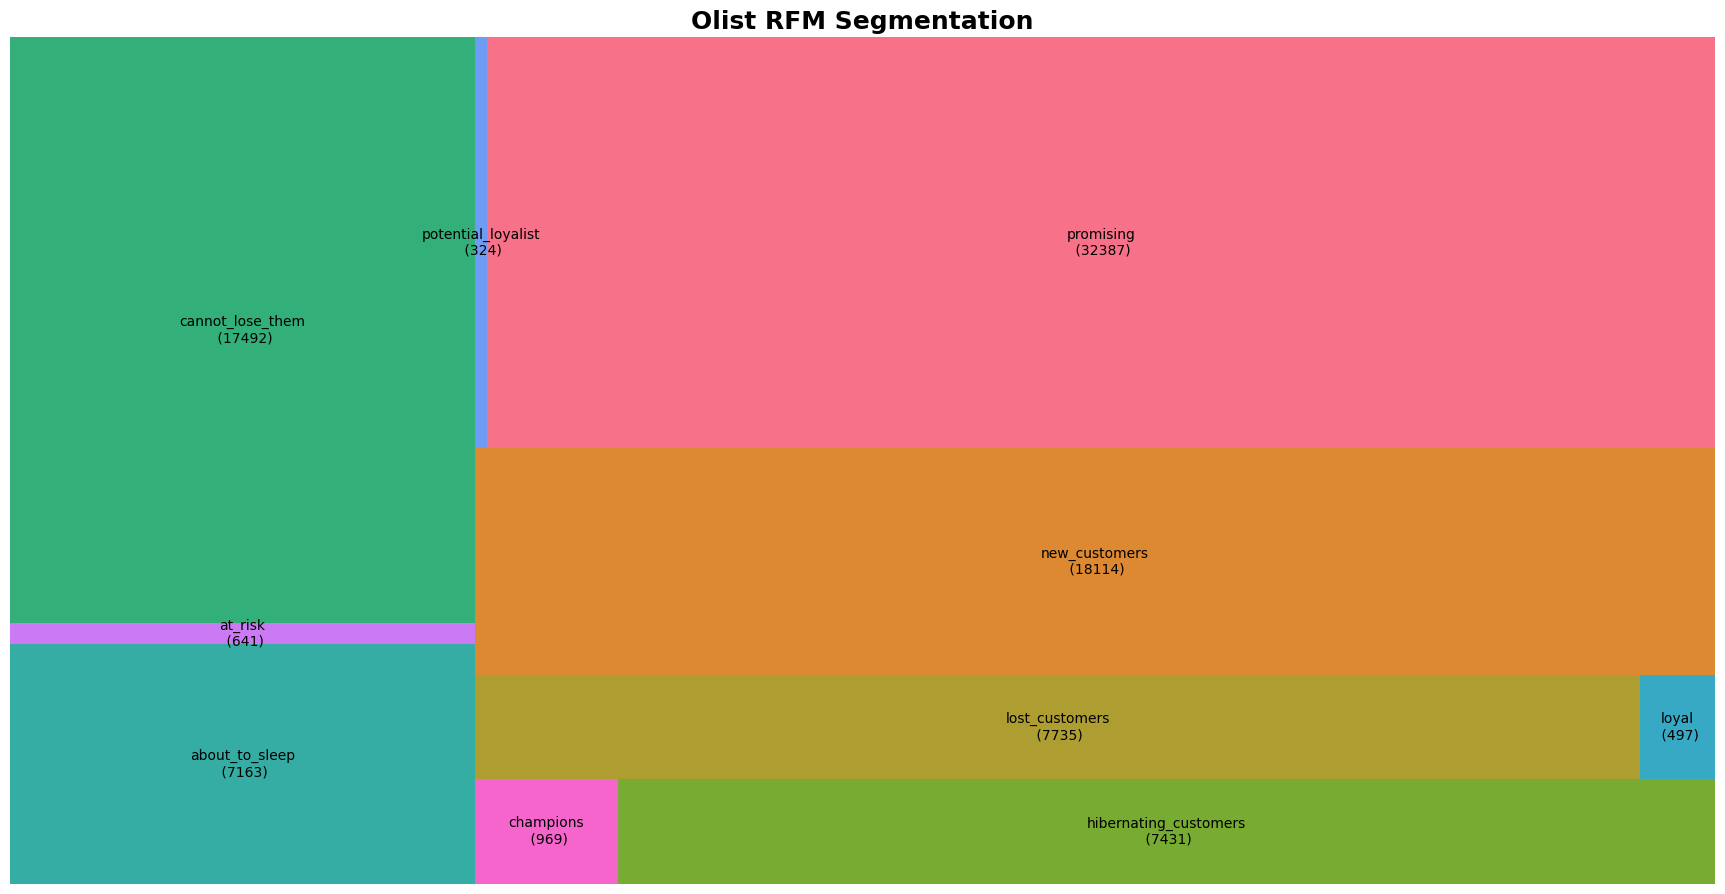

In [73]:
import squarify
rfmm = rfm.groupby("rfm_score_label").size().reset_index(name="counts")
labels = rfmm.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
labels_short = rfmm.apply(lambda x: str(x[0]), axis=1).tolist()

LIST_COLORS = []
for label in labels_short:
    LIST_COLORS.append(rfm_colors.get(label))

sizes = rfmm["counts"].values.tolist()

plt.figure(figsize=(22, 11))
plt.title("Olist RFM Segmentation", size=18, fontweight="bold")
plt.axis('off')
squarify.plot(sizes=sizes, label=labels, norm_x=100,
              norm_y=100, color=LIST_COLORS, alpha=1)
plt.show()


In [74]:
rfm = rfm.drop(columns=["r_score", "f_score", "m_score", "rfm_score"])


In [75]:
rfm['rfm_score_label'].value_counts()


promising                32387
new_customers            18114
cannot_lose_them         17492
lost_customers            7735
hibernating_customers     7431
about_to_sleep            7163
champions                  969
at_risk                    641
loyal                      497
potential_loyalist         324
Name: rfm_score_label, dtype: int64

In [76]:
rfm


customer_unique_id order_purchase_timestamp  recency  \
0      0000366f3b9a7992bf8c76cfdf3221e2               2018-05-10      111   
1      0000b849f77a49e4a4ce2b2a4ca5be3f               2018-05-07      114   
2      0000f46a3911fa3c0805444483337064               2017-03-10      537   
3      0000f6ccb0745a6a4b88665a16c9f078               2017-10-12      321   
4      0004aac84e0df4da2b147fca70cf8255               2017-11-14      288   
...                                 ...                      ...      ...   
92748  fffcf5a5ff07b0908bd4e2dbc735a684               2017-06-08      447   
92749  fffea47cd6d3cc0a88bd621562a9d061               2017-12-10      262   
92750  ffff371b4d645b6ecea244b27531430a               2017-02-07      568   
92751  ffff5962728ec6157033ef9805bacc48               2018-05-02      119   
92752  ffffd2657e2aad2907e67c3e9daecbeb               2017-05-02      484   

       frequency  monetary        rfm_score_label  
0              1    141.90              promising  
1              1     27.19          new_customers  
2              1     86.22         lost_customers  
3              1     43.62  hibernating_customers  
4              1    196.89       cannot_lose_them  
...          ...       ...                    ...  
92748          1   2067.42       cannot_lose_them  
92749          1     84.58         about_to_sleep  
92750          1    112.46       cannot_lose_them  
92751          1    133.69              promising  
92752          1     71.56         lost_customers  

[92753 rows x 6 columns]

In [77]:
rfm.to_csv('pret_pour_simulation_rfm.csv', index=False)


In [78]:
# Dernier regroupement par client
orders_custom = df[["customer_unique_id", "order_id"]
                   ].groupby(by=["customer_unique_id"]).count()
orders_custom.sort_values(by="order_id", ascending=False)
orders_custom = orders_custom.rename(columns={'order_id': 'n_orders'})
reviews = df[["customer_unique_id", "review_score"]
             ].groupby(by=["customer_unique_id"]).mean()
df = df.groupby(by=["customer_unique_id"]).sum().drop(columns=['review_score'])


In [79]:
df = pd.merge(df, orders_custom, on="customer_unique_id")
df = pd.merge(df, reviews, on="customer_unique_id")
df = pd.merge(df, rfm, on="customer_unique_id").drop(
    columns=['payment_value', 'n_orders'])


In [80]:
df.columns


Index(['customer_unique_id', 'payment_sequential', 'order_weight',
       'construction', 'electronics', 'fashion', 'home', 'leisure', 'others',
       'review_comment', 'review_score', 'order_purchase_timestamp', 'recency',
       'frequency', 'monetary', 'rfm_score_label'],
      dtype='object')

In [81]:
id_cols = ['customer_unique_id']
quanti_cols = ['payment_sequential', 'order_weight',
               'construction', 'electronics', 'fashion', 'home', 'leisure', 'others',
               'review_comment', 'review_score', 'recency',
               'frequency', 'monetary']
quali_cols = ['rfm_score_label']


In [82]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 92753 entries, 0 to 92752
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        92753 non-null  object 
 1   payment_sequential        92753 non-null  int64  
 2   order_weight              92753 non-null  float64
 3   construction              92753 non-null  int32  
 4   electronics               92753 non-null  int32  
 5   fashion                   92753 non-null  int32  
 6   home                      92753 non-null  int32  
 7   leisure                   92753 non-null  int32  
 8   others                    92753 non-null  int32  
 9   review_comment            92753 non-null  float64
 10  review_score              92753 non-null  float64
 11  order_purchase_timestamp  92753 non-null  object 
 12  recency                   92753 non-null  int64  
 13  frequency                 92753 non-null  int64  
 14  moneta

<Axes: >

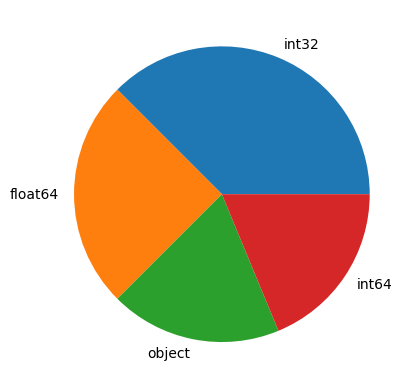

In [83]:
df.dtypes.value_counts().plot.pie()


In [84]:
def data_optimize(df, object_option=False):
    """Reduce the size of the input dataframe
    Parameters
    ----------
    df: pd.DataFrame
        input DataFrame
    object_option : bool, default=False
        if true, try to convert object to category
    Returns
    -------
    df: pd.DataFrame
        data type optimized output dataframe
    """

    # loop columns in the dataframe to downcast the dtype
    for col in df.columns:
        # process the int columns
        if df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()
            # if all are non-negative, change to uint
            if col_min >= 0:
                if col_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif col_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif col_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col]
            else:
                # if it has negative values, downcast based on the min and max
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col]

        # process the float columns
        elif df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()
            # downcast based on the min and max
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col]

        if object_option:
            if df[col].dtype == 'object':
                if len(df[col].value_counts()) < 0.5 * df.shape[0]:
                    df[col] = df[col].astype('category')

    return df


In [85]:
data_optimize(df, object_option=False)


customer_unique_id  payment_sequential  order_weight  \
0      0000366f3b9a7992bf8c76cfdf3221e2                   1        1500.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                   1         375.0   
2      0000f46a3911fa3c0805444483337064                   1        1500.0   
3      0000f6ccb0745a6a4b88665a16c9f078                   1         150.0   
4      0004aac84e0df4da2b147fca70cf8255                   1        6050.0   
...                                 ...                 ...           ...   
92748  fffcf5a5ff07b0908bd4e2dbc735a684                   1       60000.0   
92749  fffea47cd6d3cc0a88bd621562a9d061                   1        1720.0   
92750  ffff371b4d645b6ecea244b27531430a                   1         600.0   
92751  ffff5962728ec6157033ef9805bacc48                   1         444.0   
92752  ffffd2657e2aad2907e67c3e9daecbeb                   1         400.0   

       construction  electronics  fashion  home  leisure  others  \
0                 0            0        0     1        0       0   
1                 0            0        1     0        0       0   
2                 0            0        0     0        0       1   
3                 0            1        0     0        0       0   
4                 0            1        0     0        0       0   
...             ...          ...      ...   ...      ...     ...   
92748             0            0        2     0        0       0   
92749             0            0        0     0        0       1   
92750             0            0        0     0        0       1   
92751             0            0        1     0        0       0   
92752             0            0        1     0        0       0   

       review_comment  review_score order_purchase_timestamp  recency  \
0               126.0           5.0               2018-05-10      111   
1                 0.0           4.0               2018-05-07      114   
2                 0.0           3.0               2017-03-10      537   
3                12.0           4.0               2017-10-12      321   
4                 0.0           5.0               2017-11-14      288   
...               ...           ...                      ...      ...   
92748             0.0           5.0               2017-06-08      447   
92749             0.0           4.0               2017-12-10      262   
92750             0.0           5.0               2017-02-07      568   
92751           141.0           5.0               2018-05-02      119   
92752             0.0           5.0               2017-05-02      484   

       frequency     monetary        rfm_score_label  
0              1   141.899994              promising  
1              1    27.190001          new_customers  
2              1    86.220001         lost_customers  
3              1    43.619999  hibernating_customers  
4              1   196.889999       cannot_lose_them  
...          ...          ...                    ...  
92748          1  2067.419922       cannot_lose_them  
92749          1    84.580002         about_to_sleep  
92750          1   112.459999       cannot_lose_them  
92751          1   133.690002              promising  
92752          1    71.559998         lost_customers  

[92753 rows x 16 columns]

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4. Analyse exploratoire </h3>
</div>

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Verification NaN</h4>
</div>

In [86]:
df.isna().sum()


customer_unique_id          0
payment_sequential          0
order_weight                0
construction                0
electronics                 0
fashion                     0
home                        0
leisure                     0
others                      0
review_comment              0
review_score                0
order_purchase_timestamp    0
recency                     0
frequency                   0
monetary                    0
rfm_score_label             0
dtype: int64

In [87]:
df.loc[df[['customer_unique_id']].duplicated(keep=False), :]


Empty DataFrame
Columns: [customer_unique_id, payment_sequential, order_weight, construction, electronics, fashion, home, leisure, others, review_comment, review_score, order_purchase_timestamp, recency, frequency, monetary, rfm_score_label]
Index: []

In [88]:
df.describe()


payment_sequential   order_weight  construction   electronics  \
count        92753.000000   92753.000000  92753.000000  92753.000000   
mean             1.174539    2461.524170      0.070596      0.176027   
std              2.593914    4929.631836      0.338723      0.474907   
min              1.000000       0.000000      0.000000      0.000000   
25%              1.000000     300.000000      0.000000      0.000000   
50%              1.000000     792.000000      0.000000      0.000000   
75%              1.000000    2150.000000      0.000000      0.000000   
max            351.000000  184400.000000     15.000000     24.000000   

            fashion          home       leisure        others  review_comment  \
count  92753.000000  92753.000000  92753.000000  92753.000000    92753.000000   
mean       0.267280      0.323407      0.165288      0.176436       29.685886   
std        0.519779      0.664160      0.429060      0.445368       50.330124   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%        0.000000      0.000000      0.000000      0.000000        0.000000   
50%        0.000000      0.000000      0.000000      0.000000        0.000000   
75%        0.000000      1.000000      0.000000      0.000000       44.000000   
max       21.000000     18.000000     10.000000     12.000000      583.000000   

       review_score       recency     frequency      monetary  
count  92753.000000  92753.000000  92753.000000  92753.000000  
mean       4.153711    237.325909      1.033174    164.742569  
std        1.280404    152.597221      0.208417    220.575317  
min        1.000000      0.000000      1.000000      9.590000  
25%        4.000000    114.000000      1.000000     63.000000  
50%        5.000000    218.000000      1.000000    107.779999  
75%        5.000000    346.000000      1.000000    182.149994  
max        5.000000    695.000000     15.000000   7571.629883

In [89]:
df.shape


(92753, 16)

In [90]:
df.columns


Index(['customer_unique_id', 'payment_sequential', 'order_weight',
       'construction', 'electronics', 'fashion', 'home', 'leisure', 'others',
       'review_comment', 'review_score', 'order_purchase_timestamp', 'recency',
       'frequency', 'monetary', 'rfm_score_label'],
      dtype='object')

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">b. Vérification outliers</h4>
</div>

In [91]:
i = df.loc[df['order_weight'] == 184400, :].index[0]
# récupération de l'index de la transaction à 184400.0
df.iloc[i-1:i+2, ]
# 10 meubles 184kg ok cohérent


customer_unique_id  payment_sequential  order_weight  \
22250  3d475d7512c4e0be707b8f092f49e95d                   1         550.0   
22251  3d47f4368ccc8e1bb4c4a12dbda7111b                   1      184400.0   
22252  3d48da30e86c31f4a2fdd18eca676cf1                   1        1900.0   

       construction  electronics  fashion  home  leisure  others  \
22250             0            0        0     1        0       0   
22251             0            0        0    10        0       0   
22252             0            0        0     1        0       0   

       review_comment  review_score order_purchase_timestamp  recency  \
22250             0.0           4.0               2017-12-16      256   
22251            43.0           1.0               2017-10-02      331   
22252             0.0           5.0               2017-02-08      567   

       frequency     monetary   rfm_score_label  
22250          1    48.750000     new_customers  
22251          1  2234.659912  cannot_lose_them  
22252          1   322.170013  cannot_lose_them

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">c. Tranformations mathématiques et normalisation </h4>
</div>

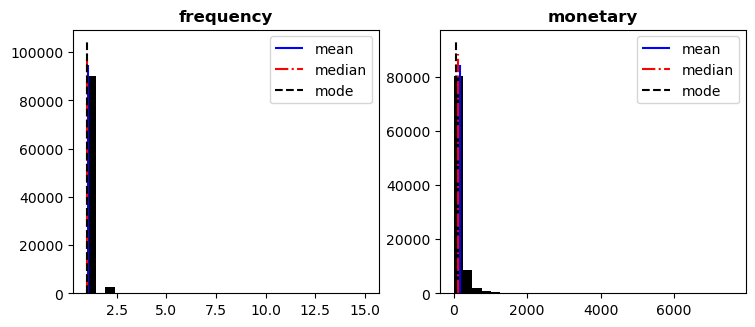

In [92]:
plot_histograms(df=df, cols=['frequency', 'monetary'], figsize=(15, 15), bins=30, layout=(5, 4), skip_outliers=False,
                thresh=2, save_enabled=False)


In [93]:
df[quanti_cols].skew()
# coefficient d'assymétrie proche de 0 pour recency.


payment_sequential    73.932461
order_weight           6.720828
construction           8.811034
electronics            6.468264
fashion                3.295465
home                   3.876688
leisure                3.375262
others                 3.652334
review_comment         2.080364
review_score          -1.478345
recency                0.447790
frequency             11.193162
monetary               7.189006
dtype: float64

In [94]:
df.columns


Index(['customer_unique_id', 'payment_sequential', 'order_weight',
       'construction', 'electronics', 'fashion', 'home', 'leisure', 'others',
       'review_comment', 'review_score', 'order_purchase_timestamp', 'recency',
       'frequency', 'monetary', 'rfm_score_label'],
      dtype='object')

In [95]:
df.describe()


payment_sequential   order_weight  construction   electronics  \
count        92753.000000   92753.000000  92753.000000  92753.000000   
mean             1.174539    2461.524170      0.070596      0.176027   
std              2.593914    4929.631836      0.338723      0.474907   
min              1.000000       0.000000      0.000000      0.000000   
25%              1.000000     300.000000      0.000000      0.000000   
50%              1.000000     792.000000      0.000000      0.000000   
75%              1.000000    2150.000000      0.000000      0.000000   
max            351.000000  184400.000000     15.000000     24.000000   

            fashion          home       leisure        others  review_comment  \
count  92753.000000  92753.000000  92753.000000  92753.000000    92753.000000   
mean       0.267280      0.323407      0.165288      0.176436       29.685886   
std        0.519779      0.664160      0.429060      0.445368       50.330124   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%        0.000000      0.000000      0.000000      0.000000        0.000000   
50%        0.000000      0.000000      0.000000      0.000000        0.000000   
75%        0.000000      1.000000      0.000000      0.000000       44.000000   
max       21.000000     18.000000     10.000000     12.000000      583.000000   

       review_score       recency     frequency      monetary  
count  92753.000000  92753.000000  92753.000000  92753.000000  
mean       4.153711    237.325909      1.033174    164.742569  
std        1.280404    152.597221      0.208417    220.575317  
min        1.000000      0.000000      1.000000      9.590000  
25%        4.000000    114.000000      1.000000     63.000000  
50%        5.000000    218.000000      1.000000    107.779999  
75%        5.000000    346.000000      1.000000    182.149994  
max        5.000000    695.000000     15.000000   7571.629883

In [96]:
df.columns


Index(['customer_unique_id', 'payment_sequential', 'order_weight',
       'construction', 'electronics', 'fashion', 'home', 'leisure', 'others',
       'review_comment', 'review_score', 'order_purchase_timestamp', 'recency',
       'frequency', 'monetary', 'rfm_score_label'],
      dtype='object')

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5. Transformations mathématiques </h3>
</div>

In [97]:
norm = ['review_comment', 'review_score']
# car grandeur unités très différentes autres variables
log = ['payment_sequential', 'construction', 'electronics', 'fashion', 'home',
       'order_weight', 'leisure', 'others', 'recency', 'frequency', 'monetary']
# car grosse assymétrie positive de la distribution ->log


In [98]:
scaler = MinMaxScaler()
scaler_features = scaler.fit_transform(df[norm])
df_normalized = pd.DataFrame(scaler_features, index=df.index, columns=norm)
df_normalized


review_comment  review_score
0            0.216124          1.00
1            0.000000          0.75
2            0.000000          0.50
3            0.020583          0.75
4            0.000000          1.00
...               ...           ...
92748        0.000000          1.00
92749        0.000000          0.75
92750        0.000000          1.00
92751        0.241852          1.00
92752        0.000000          1.00

[92753 rows x 2 columns]

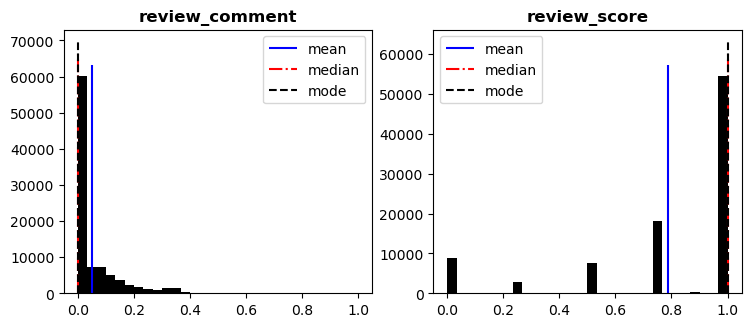

In [99]:
plot_histograms(df=df_normalized, cols=df_normalized.columns, figsize=(15, 15), bins=30, layout=(5, 4), skip_outliers=False,
                thresh=2, save_enabled=False)


In [100]:
df_transf = df[log]+1
df_transf = np.log(df_transf)
df_transf


payment_sequential  construction  electronics   fashion      home  \
0                0.693147           0.0     0.000000  0.000000  0.693359   
1                0.693147           0.0     0.000000  0.693359  0.000000   
2                0.693147           0.0     0.000000  0.000000  0.000000   
3                0.693147           0.0     0.693359  0.000000  0.000000   
4                0.693147           0.0     0.693359  0.000000  0.000000   
...                   ...           ...          ...       ...       ...   
92748            0.693147           0.0     0.000000  1.098633  0.000000   
92749            0.693147           0.0     0.000000  0.000000  0.000000   
92750            0.693147           0.0     0.000000  0.000000  0.000000   
92751            0.693147           0.0     0.000000  0.693359  0.000000   
92752            0.693147           0.0     0.000000  0.693359  0.000000   

       order_weight  leisure    others   recency  frequency  monetary  
0          7.313887      0.0  0.000000  4.718499   0.693147  4.962145  
1          5.929589      0.0  0.000000  4.744932   0.693147  3.338967  
2          7.313887      0.0  0.693359  6.287859   0.693147  4.468434  
3          5.017280      0.0  0.000000  5.774552   0.693147  3.798182  
4          8.707979      0.0  0.000000  5.666427   0.693147  5.287711  
...             ...      ...       ...       ...        ...       ...  
92748     11.002116      0.0  0.000000  6.104793   0.693147  7.634540  
92749      7.450661      0.0  0.693359  5.572154   0.693147  4.449451  
92750      6.398595      0.0  0.693359  6.343880   0.693147  4.731451  
92751      6.098074      0.0  0.000000  4.787492   0.693147  4.902976  
92752      5.993961      0.0  0.000000  6.184149   0.693147  4.284414  

[92753 rows x 11 columns]

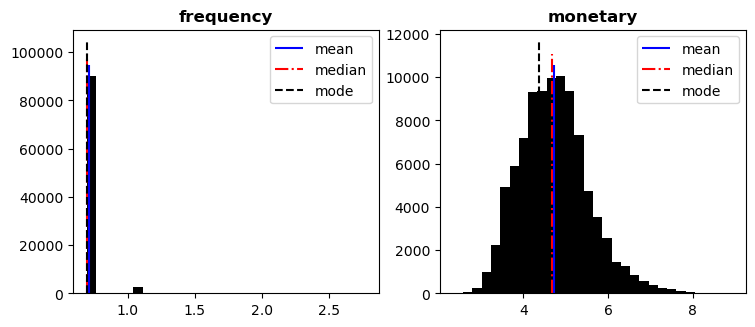

In [101]:
plot_histograms(df=df_transf, cols=['frequency', 'monetary'], figsize=(15, 15), bins=30, layout=(5, 4), skip_outliers=False,
                thresh=2, save_enabled=False)


In [102]:
scaler = MinMaxScaler()
scaler_features = scaler.fit_transform(df_transf)
df_norm = pd.DataFrame(scaler_features, index=df.index, columns=log)
df_norm


payment_sequential  construction  electronics   fashion      home  \
0                     0.0           0.0     0.000000  0.000000  0.235411   
1                     0.0           0.0     0.000000  0.224258  0.000000   
2                     0.0           0.0     0.000000  0.000000  0.000000   
3                     0.0           0.0     0.215413  0.000000  0.000000   
4                     0.0           0.0     0.215413  0.000000  0.000000   
...                   ...           ...          ...       ...       ...   
92748                 0.0           0.0     0.000000  0.355338  0.000000   
92749                 0.0           0.0     0.000000  0.000000  0.000000   
92750                 0.0           0.0     0.000000  0.000000  0.000000   
92751                 0.0           0.0     0.000000  0.224258  0.000000   
92752                 0.0           0.0     0.000000  0.224258  0.000000   

       order_weight  leisure    others   recency  frequency  monetary  
0          0.603214      0.0  0.000000  0.720893        0.0  0.395935  
1          0.489044      0.0  0.000000  0.724932        0.0  0.148965  
2          0.603214      0.0  0.270373  0.960660        0.0  0.320816  
3          0.413801      0.0  0.000000  0.882237        0.0  0.218836  
4          0.718192      0.0  0.000000  0.865718        0.0  0.445470  
...             ...      ...       ...       ...        ...       ...  
92748      0.907401      0.0  0.000000  0.932692        0.0  0.802544  
92749      0.614494      0.0  0.270373  0.851315        0.0  0.317927  
92750      0.527725      0.0  0.270373  0.969219        0.0  0.360834  
92751      0.502939      0.0  0.000000  0.731434        0.0  0.386932  
92752      0.494353      0.0  0.000000  0.944816        0.0  0.292817  

[92753 rows x 11 columns]

In [103]:
data = df_normalized.join(df_norm)


In [104]:
data.describe()


review_comment  review_score  payment_sequential  construction  \
count    92753.000000  92753.000000        92753.000000  92753.000000   
mean         0.050919      0.788428            0.007778      0.015902   
std          0.086319      0.320101            0.037737      0.067565   
min          0.000000      0.000000            0.000000      0.000000   
25%          0.000000      0.750000            0.000000      0.000000   
50%          0.000000      1.000000            0.000000      0.000000   
75%          0.075472      1.000000            0.000000      0.000000   
max          1.000000      1.000000            1.000000      1.000000   

        electronics       fashion          home  order_weight       leisure  \
count  92753.000000  92753.000000  92753.000000  92753.000000  92753.000000   
mean       0.035598      0.057358      0.068457      0.561278      0.045506   
std        0.085814      0.103619      0.122289      0.112396      0.111547   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.470695      0.000000   
50%        0.000000      0.000000      0.000000      0.550589      0.000000   
75%        0.000000      0.000000      0.235411      0.632888      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             others       recency     frequency      monetary  
count  92753.000000  92753.000000  92753.000000  92753.000000  
mean       0.045402      0.788376      0.006230      0.360309  
std        0.107097      0.143857      0.036738      0.122883  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.724932      0.000000      0.273717  
50%        0.000000      0.823344      0.000000      0.354425  
75%        0.000000      0.893661      0.000000      0.433693  
max        1.000000      1.000000      1.000000      1.000000

In [105]:
data["ID"] = df["customer_unique_id"]
data["rfm_label"] = df["rfm_score_label"]


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">d. Corrélation entre les variables</h4>
</div>

In [106]:
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', robust=False):
    
    fig, ax = plt.subplots(figsize=figsize)
    if shape == 'rect':
        mask=None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        print('ERROR : this type of heatmap does not exist')

    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt=fmt,
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None}, robust = robust,
                     xticklabels= corr.columns, yticklabels = corr.index)
    ax.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)

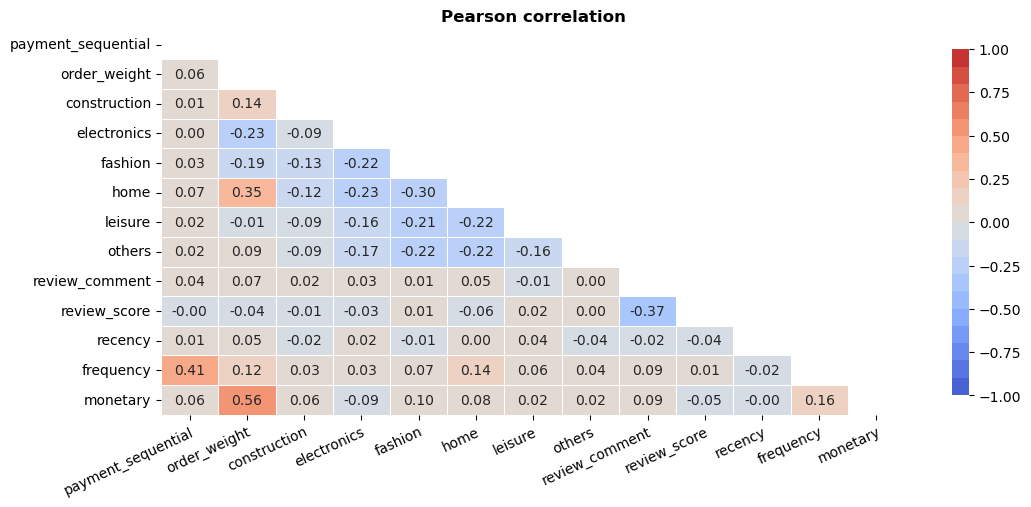

In [107]:
pears_corr = data[quanti_cols].corr()
plot_heatmap(pears_corr, shape='tri',
             title="Pearson correlation", figsize=(12, 5))
plt.show()


In [108]:
import plotly.express as px
import plotly.io as pio

fig = px.scatter_3d(data, x='recency', y='frequency', z='monetary',
                    color=df.rfm_score_label)

pio.show(fig)


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6. Export </h3>
</div>

In [109]:
data["order_purchase_timestamp"] = df["order_purchase_timestamp"]
data = data.drop(columns=['review_comment'])


In [110]:
data.describe(include='all')


review_score  payment_sequential  construction   electronics  \
count   92753.000000        92753.000000  92753.000000  92753.000000   
unique           NaN                 NaN           NaN           NaN   
top              NaN                 NaN           NaN           NaN   
freq             NaN                 NaN           NaN           NaN   
mean        0.788428            0.007778      0.015902      0.035598   
std         0.320101            0.037737      0.067565      0.085814   
min         0.000000            0.000000      0.000000      0.000000   
25%         0.750000            0.000000      0.000000      0.000000   
50%         1.000000            0.000000      0.000000      0.000000   
75%         1.000000            0.000000      0.000000      0.000000   
max         1.000000            1.000000      1.000000      1.000000   

             fashion          home  order_weight       leisure        others  \
count   92753.000000  92753.000000  92753.000000  92753.000000  92753.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        0.057358      0.068457      0.561278      0.045506      0.045402   
std         0.103619      0.122289      0.112396      0.111547      0.107097   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.000000      0.000000      0.470695      0.000000      0.000000   
50%         0.000000      0.000000      0.550589      0.000000      0.000000   
75%         0.000000      0.235411      0.632888      0.000000      0.000000   
max         1.000000      1.000000      1.000000      1.000000      1.000000   

             recency     frequency      monetary  \
count   92753.000000  92753.000000  92753.000000   
unique           NaN           NaN           NaN   
top              NaN           NaN           NaN   
freq             NaN           NaN           NaN   
mean        0.788376      0.006230      0.360309   
std         0.143857      0.036738      0.122883   
min         0.000000      0.000000      0.000000   
25%         0.724932      0.000000      0.273717   
50%         0.823344      0.000000      0.354425   
75%         0.893661      0.000000      0.433693   
max         1.000000      1.000000      1.000000   

                                      ID  rfm_label order_purchase_timestamp  
count                              92753      92753                    92753  
unique                             92753         10                      610  
top     0000366f3b9a7992bf8c76cfdf3221e2  promising               2017-11-24  
freq                                   1      32387                     1106  
mean                                 NaN        NaN                      NaN  
std                                  NaN        NaN                      NaN  
min                                  NaN        NaN                      NaN  
25%                                  NaN        NaN                      NaN  
50%                                  NaN        NaN                      NaN  
75%                                  NaN        NaN                      NaN  
max                                  NaN        NaN                      NaN

In [111]:
data.to_csv('df_complet_segmentation.csv', index=False)
